In [1]:
%matplotlib inline
from IPython.core.display import display, HTML  
display(HTML("<style>.container { width:95% !important; }</style>")) #bigger notebook

In [2]:
from __future__ import division

import tensorflow as tf
print 'TensorFlow version:', tf.__version__

import numpy as np
import datetime
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set() # use seaborn plotting defaults

TensorFlow version: 0.7.1


$A^n + B^n$ : element-wise

+ Multi GPU: Compute $A^n$  and $B^n$ on 2 different GPUs and '+' operation is on CPU
    
+ Single GPU: Compute $A^n$  and $B^n$ on the same GPU and '+' operation is on CPU

Note: The first call to eval() or run() is typically much slower than subsequent calls since it needs to setup the session. Subsequent calls to eval/run are typically much faster


In [ ]:
matrix_size = [2, 50, 100, 500, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10000]
single_gpu = []
multi_gpu = []
results = []

n = 30
    
for s in matrix_size:
    A = np.random.rand(s, s).astype('float32')
    B = np.random.rand(s, s).astype('float32')

    with tf.Graph().as_default(): # to avoid copies nodes in the graph
        c = []    
        with tf.device('/gpu:0'):
            a = tf.constant(A)
            ap = tf.pow(a, n)    
            c.append(ap)

        with tf.device('/gpu:1'):    
            b = tf.constant(B)
            bp = tf.pow(a, n)    
            c.append(bp)

        with tf.device('/gpu:0'):
            sum = tf.add_n(c)

        t1_begin = datetime.datetime.now()
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:    
            sess.run(sum) # Runs the op.
        t1_end = datetime.datetime.now()
        
        multi_gpu.append((t1_end - t1_begin).total_seconds())
        
    with tf.Graph().as_default():
        c = []
        with tf.device('/gpu:0'):
            a = tf.constant(A)
            b = tf.constant(B)
            ap = tf.pow(a, n)
            bp = tf.pow(b, n)
            c.append(ap)
            c.append(bp)
            sum = tf.add_n(c)

        t2_begin = datetime.datetime.now()
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:    
            sess.run(sum) # Runs the op. ; automatic close session
        t2_end = datetime.datetime.now()

        single_gpu.append((t2_end- t2_begin).total_seconds())
        
    #print '\nMatrix size: ', A.shape
    #print 'Single GPU computation time: ' + str((t2_end- t2_begin).total_seconds())
    #print '2-GPU computation time: ' + str((t1_end - t1_begin).total_seconds())

    results.append([A.shape,(t2_end- t2_begin).total_seconds(), (t1_end - t1_begin).total_seconds()])
    

labels = ['2', '50', '100', '500', '1000', '1500', '2000', '3000', '4000', '6000', '8000', '10000']
x = [i for i in range(len(labels))]
fig = plt.figure(figsize=(7, 5))
figure = plt.gcf()

plt.plot(single_gpu, marker='v', linestyle='-', color='green', linewidth=2, label='Single GPU')
plt.plot(multi_gpu, marker='H', linestyle='-', color='red', linewidth=2, label='2 GPUs')
plt.xticks(x, labels)

plt.title('TensorFlow: 1-GPU vs. 2-GPU')
plt.xlabel('Matrix size', fontsize='14')
plt.ylabel('Time in seconds', fontsize='14')
plt.legend(loc='best', fontsize='18')
plt.show()
fig.savefig('TensorFlow_1_vs_2_GPUs.png')
plt.close(fig)


print single_gpu
print multi_gpu
print tabulate(results, headers=['Matrix size', '1-GPU', '2-GPU'])

Theano version: 0.9.0dev1.dev-2b86de9d80cba33fcec14ee8941c423713eb94ee
Matrix size: (2, 2) Compile: 0.030815 Run: 0.000119 Total time: 0.030934
Matrix size: (50, 50) Compile: 0.023456 Run: 8.7e-05 Total time: 0.023543
Matrix size: (100, 100) Compile: 0.023316 Run: 0.000109 Total time: 0.023425
Matrix size: (500, 500) Compile: 0.022271 Run: 0.001426 Total time: 0.023697
Matrix size: (1000, 1000) Compile: 0.022929 Run: 0.00552 Total time: 0.028449
Matrix size: (1500, 1500) Compile: 0.023278 Run: 0.009848 Total time: 0.033126
Matrix size: (2000, 2000) Compile: 0.02152 Run: 0.017014 Total time: 0.038534
Matrix size: (3000, 3000) Compile: 0.021126 Run: 0.04053 Total time: 0.061656
Matrix size: (4000, 4000) Compile: 0.021236 Run: 0.071716 Total time: 0.092952
Matrix size: (6000, 6000) Compile: 0.022428 Run: 0.159916 Total time: 0.182344
Matrix size: (8000, 8000) Compile: 0.021469 Run: 0.283292 Total time: 0.304761
Matrix size: (10000, 10000) Compile: 0.021646 Run: 0.443214 Total time: 0.4648

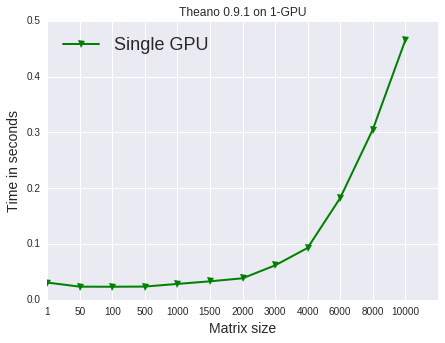

[0.030934, 0.023543, 0.023425, 0.023697, 0.028449000000000002, 0.033126, 0.038534, 0.061655999999999996, 0.092952, 0.182344, 0.304761, 0.46486]


In [4]:
import theano
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0") # using a GPU
print 'Theano version:', theano.__version__

from theano import tensor as T
from theano import function, scan

import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set() # use seaborn plotting defaults

n = 2
matrix_size = [2, 50, 100, 500, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10000]

theano_time = []

for s in matrix_size:
    
    t1_begin = datetime.datetime.now()

    a = T.dmatrix('a')      # declare variable
    b = T.dmatrix('b')
    ap = T.pow(a, n)
    bp = T.pow(b, n)
    
    c = ap + bp         # build symbolic expression
    #c = a**n + b**n         # build symbolic expression
     
    f = function([a, b], c) # compile function

    t1_end = datetime.datetime.now()
    compile_time = (t1_end- t1_begin).total_seconds()
    #print "Compilation time: " + str(compile_time)
    
    A = np.random.rand(s, s).astype('float32')
    B = np.random.rand(s, s).astype('float32')
    t2_begin = datetime.datetime.now()
    f(A, B)    
    
    t2_end = datetime.datetime.now()
    run_time = (t2_end- t2_begin).total_seconds()
    total_time = compile_time + run_time
    theano_time.append(total_time)
    print 'Matrix size:', A.shape , 'Compile:', str(compile_time), 'Run:', str(run_time), 'Total time:', str(total_time)

    
labels = ['1', '50', '100', '500', '1000', '1500', '2000', '3000', '4000', '6000', '8000', '10000']
x = [i for i in range(len(labels))]
fig = plt.figure(figsize=(7, 5))
figure = plt.gcf()

plt.plot(theano_time, marker='v', linestyle='-', color='green', linewidth=2, label='Single GPU')
plt.xticks(x, labels)

plt.title('Theano 0.9.1 on 1-GPU')
plt.xlabel('Matrix size', fontsize='14')
plt.ylabel('Time in seconds', fontsize='14')
plt.legend(loc='best', fontsize='18')
plt.show()

print theano_time

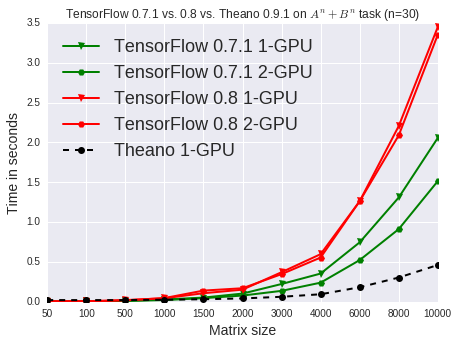

In [5]:
labels = ['50', '100', '500', '1000', '1500', '2000', '3000', '4000', '6000', '8000', '10000']

x = [i for i in range(len(labels))]

# TensorFlow 0.7.1
single_gpu_071 = [0.005299, 0.006305, 0.012287, 0.028733, 0.052875, 0.103011, 0.22313, 0.354109, 0.74593, 1.308769, 2.055922]
multi_gpu_071 = [0.00772, 0.006099, 0.010816, 0.021379, 0.045656, 0.078372, 0.137304, 0.240004, 0.523093, 0.911741, 1.514064]

# TensorFlow 0.8
single_gpu_08 = [0.007697, 0.007412, 0.021353, 0.044482, 0.107647, 0.152225, 0.371428, 0.597583, 1.261837, 2.205294, 3.44751]
multi_gpu_08 = [0.005094, 0.005267, 0.018319, 0.046661, 0.140644, 0.17001, 0.34707, 0.555248, 1.262252, 2.088138, 3.350551]

# Theano 0.9.1
theano_time= [0.021824, 0.021326, 0.021508, 0.025671, 0.032332, 0.042162000000000005, 0.06290699999999999, 0.094614, 0.18231699999999998, 0.304214, 0.461654]

fig = plt.figure(figsize=(7, 5))
figure = plt.gcf()

plt.plot(single_gpu_071, marker='v', linestyle='-', color='green', linewidth=2, label='TensorFlow 0.7.1 1-GPU')
plt.plot(multi_gpu_071, marker='H', linestyle='-', color='green', linewidth=2, label='TensorFlow 0.7.1 2-GPU')

plt.plot(single_gpu_08, marker='v', linestyle='-', color='red', linewidth=2, label='TensorFlow 0.8 1-GPU')
plt.plot(multi_gpu_08, marker='H', linestyle='-', color='red', linewidth=2, label='TensorFlow 0.8 2-GPU')

plt.plot(theano_time, marker='o', linestyle='--', color='black', linewidth=2, label='Theano 1-GPU')
plt.xticks(x, labels)

plt.title('TensorFlow 0.7.1 vs. 0.8 vs. Theano 0.9.1 on $A^n + B^n$ task (n=30)')
plt.xlabel('Matrix size', fontsize='14')
plt.ylabel('Time in seconds', fontsize='14')
plt.legend(loc='best', fontsize='18')
plt.show()
fig.savefig('TensorFlow_vs_Theano.png')
plt.close(fig)
